In [1]:
%matplotlib inline
import sys
import math

from logging import info
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import xgboost as xgb
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE

import features

from dataset import read_datasets, read_leap_motion_data
from features import extract_features, extract_lp_features
from train import precision_for, train_clf, feature_precisions
from utils import print_log, set_cache, get_cache, select_features, find_best_params
from draw import plot

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Load
ORIGIN_DATA = False
load_cache = True
if ORIGIN_DATA:
    persons = read_datasets(load_cache=load_cache)
else:
    persons = read_leap_motion_data('LP_data/dataset', load_cache=load_cache)

Trying fetch cache for persons
Using cache for persons
Time for >>read_leap_motion_data<<: 7.55 s


In [3]:
# Feature Extraction
raw_A = []
y = []
for p in persons:
    for g_idx in range(1, 11):
        for idx in range(1, 21):
            g = 'G{}'.format(g_idx)
            if ORIGIN_DATA:
                if idx > 10:
                    break
                d = persons[p][g][idx]['lm']
                f = extract_features(d)
            else:
                try:
                    d = persons[p][g][idx]['json']
                except Exception as e:
                    print(p, g, idx)
                f = extract_lp_features(d)
            raw_A.append(f)
            y.append(g_idx-1)
del persons
raw_A = np.array(raw_A)
y = np.array(y)

# Norm D and E
den = raw_A[:, 7][:, None]
den[den == 0] = 1e9  # Infinity
raw_A[:, 5:15] = raw_A[:, 5:15] / den # dividing the values for the distance between the hand center and the middle fingertip S

# Norm T
den = np.max(raw_A[:, 15:25], axis=1)[:, None]
den[den == 0] = 1e9
raw_A[:, 15:25] = raw_A[:, 15:25] / den

raw_A[raw_A < 1e-5] = 0

all_data = pd.DataFrame(np.append(raw_A, y.reshape((-1, 1)), axis=1))
all_data.to_csv('caches/feature_set.csv', index=False, float_format='%.3f')
all_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.875321,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [4]:
feature_sels = {
    'A': features.F_A,
    'D': features.F_D,
    'E': features.F_E,
    'T': features.F_T,
    'A+D': features.F_A | features.F_D,
    'A+E': features.F_A | features.F_E,
    'A+T': features.F_A | features.F_T,
    'D+E': features.F_D | features.F_E,
    'D+T': features.F_D | features.F_T,
    'E+T': features.F_E | features.F_T,
    'A+D+E': features.F_A | features.F_D | features.F_E,
    'A+D+T': features.F_A | features.F_D | features.F_T,
    'A+E+T': features.F_A | features.F_E | features.F_T,
    'D+E+T': features.F_D | features.F_E | features.F_T,
    'A+D+E+T': features.F_ALL,
}
iter_times = 50

In [5]:
# best_params = {}
# for key, val in feature_sels.items():
#     x = select_features(raw_A, val)
#     params = find_best_params(x, y, label=key)
#     best_params[key] = params
best_params = find_best_params(raw_A, y, label='')

------------------------------
# Tuning hyper-parameters for 

Grid scores on development set:

0.748 (+/-0.049) for {'estimator__C': 1, 'estimator__gamma': 1}
0.692 (+/-0.053) for {'estimator__C': 1, 'estimator__gamma': 0.1}
0.642 (+/-0.072) for {'estimator__C': 1, 'estimator__gamma': 0.01}
0.237 (+/-0.039) for {'estimator__C': 1, 'estimator__gamma': 0.001}
0.113 (+/-0.054) for {'estimator__C': 1, 'estimator__gamma': 0.0001}
0.791 (+/-0.057) for {'estimator__C': 10, 'estimator__gamma': 1}
0.750 (+/-0.051) for {'estimator__C': 10, 'estimator__gamma': 0.1}
0.687 (+/-0.052) for {'estimator__C': 10, 'estimator__gamma': 0.01}
0.642 (+/-0.070) for {'estimator__C': 10, 'estimator__gamma': 0.001}
0.235 (+/-0.038) for {'estimator__C': 10, 'estimator__gamma': 0.0001}
0.818 (+/-0.068) for {'estimator__C': 100, 'estimator__gamma': 1}
0.784 (+/-0.054) for {'estimator__C': 100, 'estimator__gamma': 0.1}
0.742 (+/-0.042) for {'estimator__C': 100, 'estimator__gamma': 0.01}
0.686 (+/-0.051) for {'estim

In [6]:
best_params

{'C': 1000, 'gamma': 1}

In [7]:
# Best parameters found by GridSearch
svm_ps = feature_precisions(raw_A, y, feature_sels, ITER_TIMES=iter_times,
                        classifier='svm', params=best_params)

Round  50/ 50:    A+T precision: 83.08%|    D+T precision: 60.00%|    E+T precision: 57.88%|  D+E+T precision: 58.85%|      D precision: 16.15%|    A+E precision: 81.54%|      E precision: 13.65%|    D+E precision: 15.77%|  A+E+T precision: 81.92%|      T precision: 56.92%|  A+D+E precision: 81.54%|      A precision: 80.19%|A+D+E+T precision: 81.73%|    A+D precision: 82.31%|  A+D+T precision: 83.08%
After  50 iterations:
-------
        A+T         
Max precision for A+T: 86.35%
Min precision for A+T: 79.04%
Avg precision for A+T: 83.55%
-------
-------
        D+T         
Max precision for D+T: 62.69%
Min precision for D+T: 56.15%
Avg precision for D+T: 59.19%
-------
-------
        E+T         
Max precision for E+T: 62.50%
Min precision for E+T: 55.58%
Avg precision for E+T: 58.97%
-------
-------
       D+E+T        
Max precision for D+E+T: 62.50%
Min precision for D+E+T: 56.15%
Avg precision for D+E+T: 59.50%
-------
-------
         D          
Max precision for D: 16.15%
Min

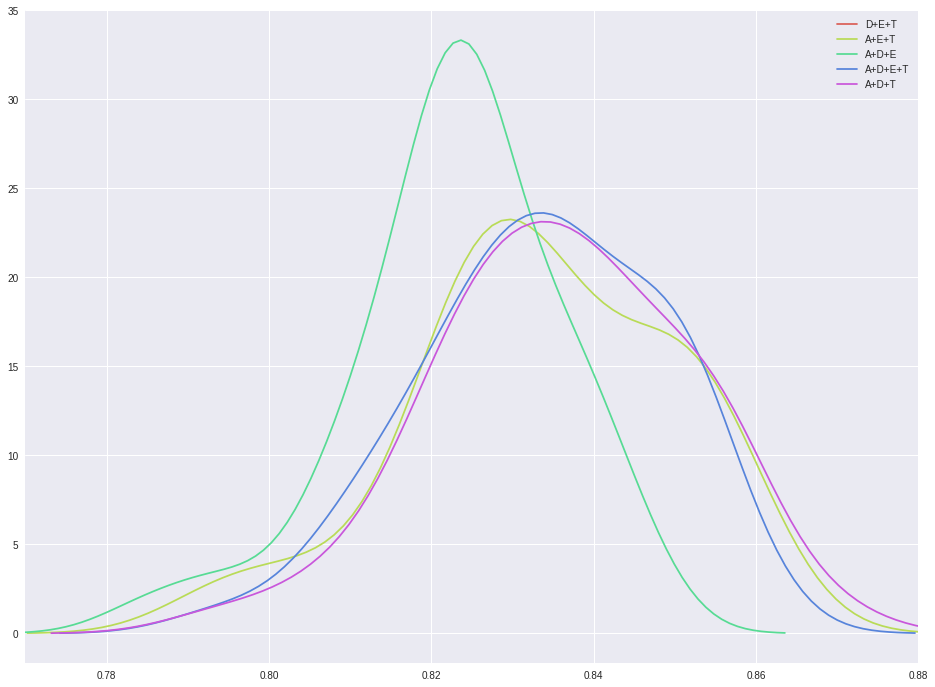

In [15]:
_svm_ps = svm_ps.copy()
del _svm_ps['A']
del _svm_ps['E']
del _svm_ps['T']
del _svm_ps['D']
del _svm_ps['A+D']
del _svm_ps['A+E']
del _svm_ps['A+T']
del _svm_ps['E+T']
del _svm_ps['D+T']
del _svm_ps['D+E']
plt.figure(figsize=(16, 12))
plt.xlim((0.77, 0.88))
colors = sns.color_palette("hls", 5)
for (key, val), color in zip(_svm_ps.items(), colors):
    plot(val, label=key, color=color)

In [9]:
agg_svm_ps = []
for key, vals in svm_ps.items():
    agg_svm_ps.append((key, sum(vals) / len(vals)))
agg_svm_ps.sort(key=lambda x: x[1], reverse=True)
for key, val in agg_svm_ps:
    print('{:8s}:  {:6.2%}'.format(key, val))

A+D+T   :  83.60%
A+T     :  83.55%
A+E+T   :  83.37%
A+D+E+T :  83.36%
A+D     :  82.38%
A+D+E   :  82.30%
A+E     :  81.56%
A       :  81.23%
D+E+T   :  59.50%
D+T     :  59.19%
E+T     :  58.97%
T       :  57.48%
D+E     :  14.48%
D       :  14.08%
E       :  12.05%


In [10]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(16, 16))
    if x.shape[1] == 2:
        ax = plt.subplot(aspect='equal')
        sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                        c=palette[colors.astype(np.int)])
    elif x.shape[1] == 3:
        ax = Axes3D(f)
        sc = ax.scatter(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                        c=palette[colors.astype(np.int)]) 

    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.legend()
    ax.axis('on')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        pos = np.median(x[colors == i, :], axis=0)
        txt = ax.text(*pos, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [11]:
tsne_x = TSNE(2).fit_transform(raw_A)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


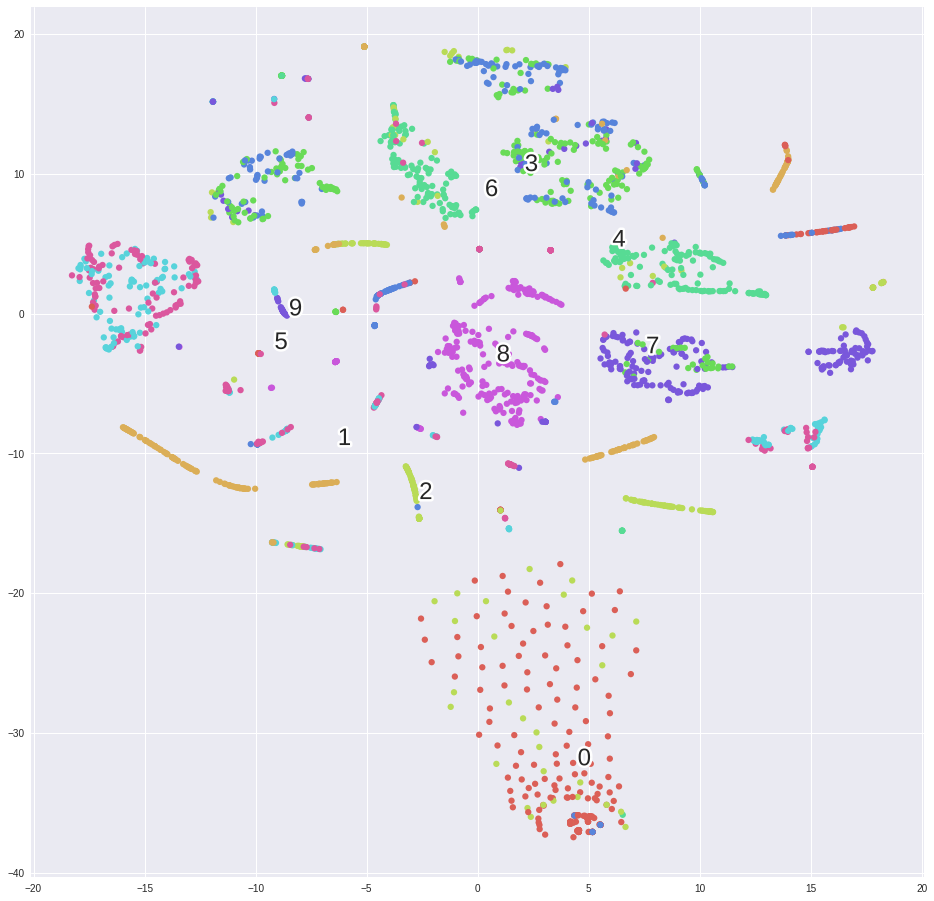

In [12]:
f, ax, sc, txts = scatter(tsne_x, y)